## Some preliminary steps: Includes, Hardware support. 

In [1]:
%run librairiesCNN.py

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


## Load network ensemble

In [2]:
from CNN_architectures import StreaksCNN

file_net = 'networks/network_grayscale_gradient_n=1M'
h5f = h5py.File(('%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

net_ensemble = []
for n in range(n_ensemble_members):
    f_output_name = '%s_%d.pytorch' % (file_net, n)
    net_ensemble.append(StreaksCNN(winSz = windowSize, \
                                   filtSz = filter_size, \
                                   convPad = padding))
    
    net_ensemble[n].load_state_dict(torch.load('%s_%d.pytorch' % (file_net, n), map_location = device))
    net_ensemble[n].to(device)
    net_ensemble[n].eval()
    
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

CNN_width=windowSize
CNN_height=windowSize
overlap=24

## Load experimental image

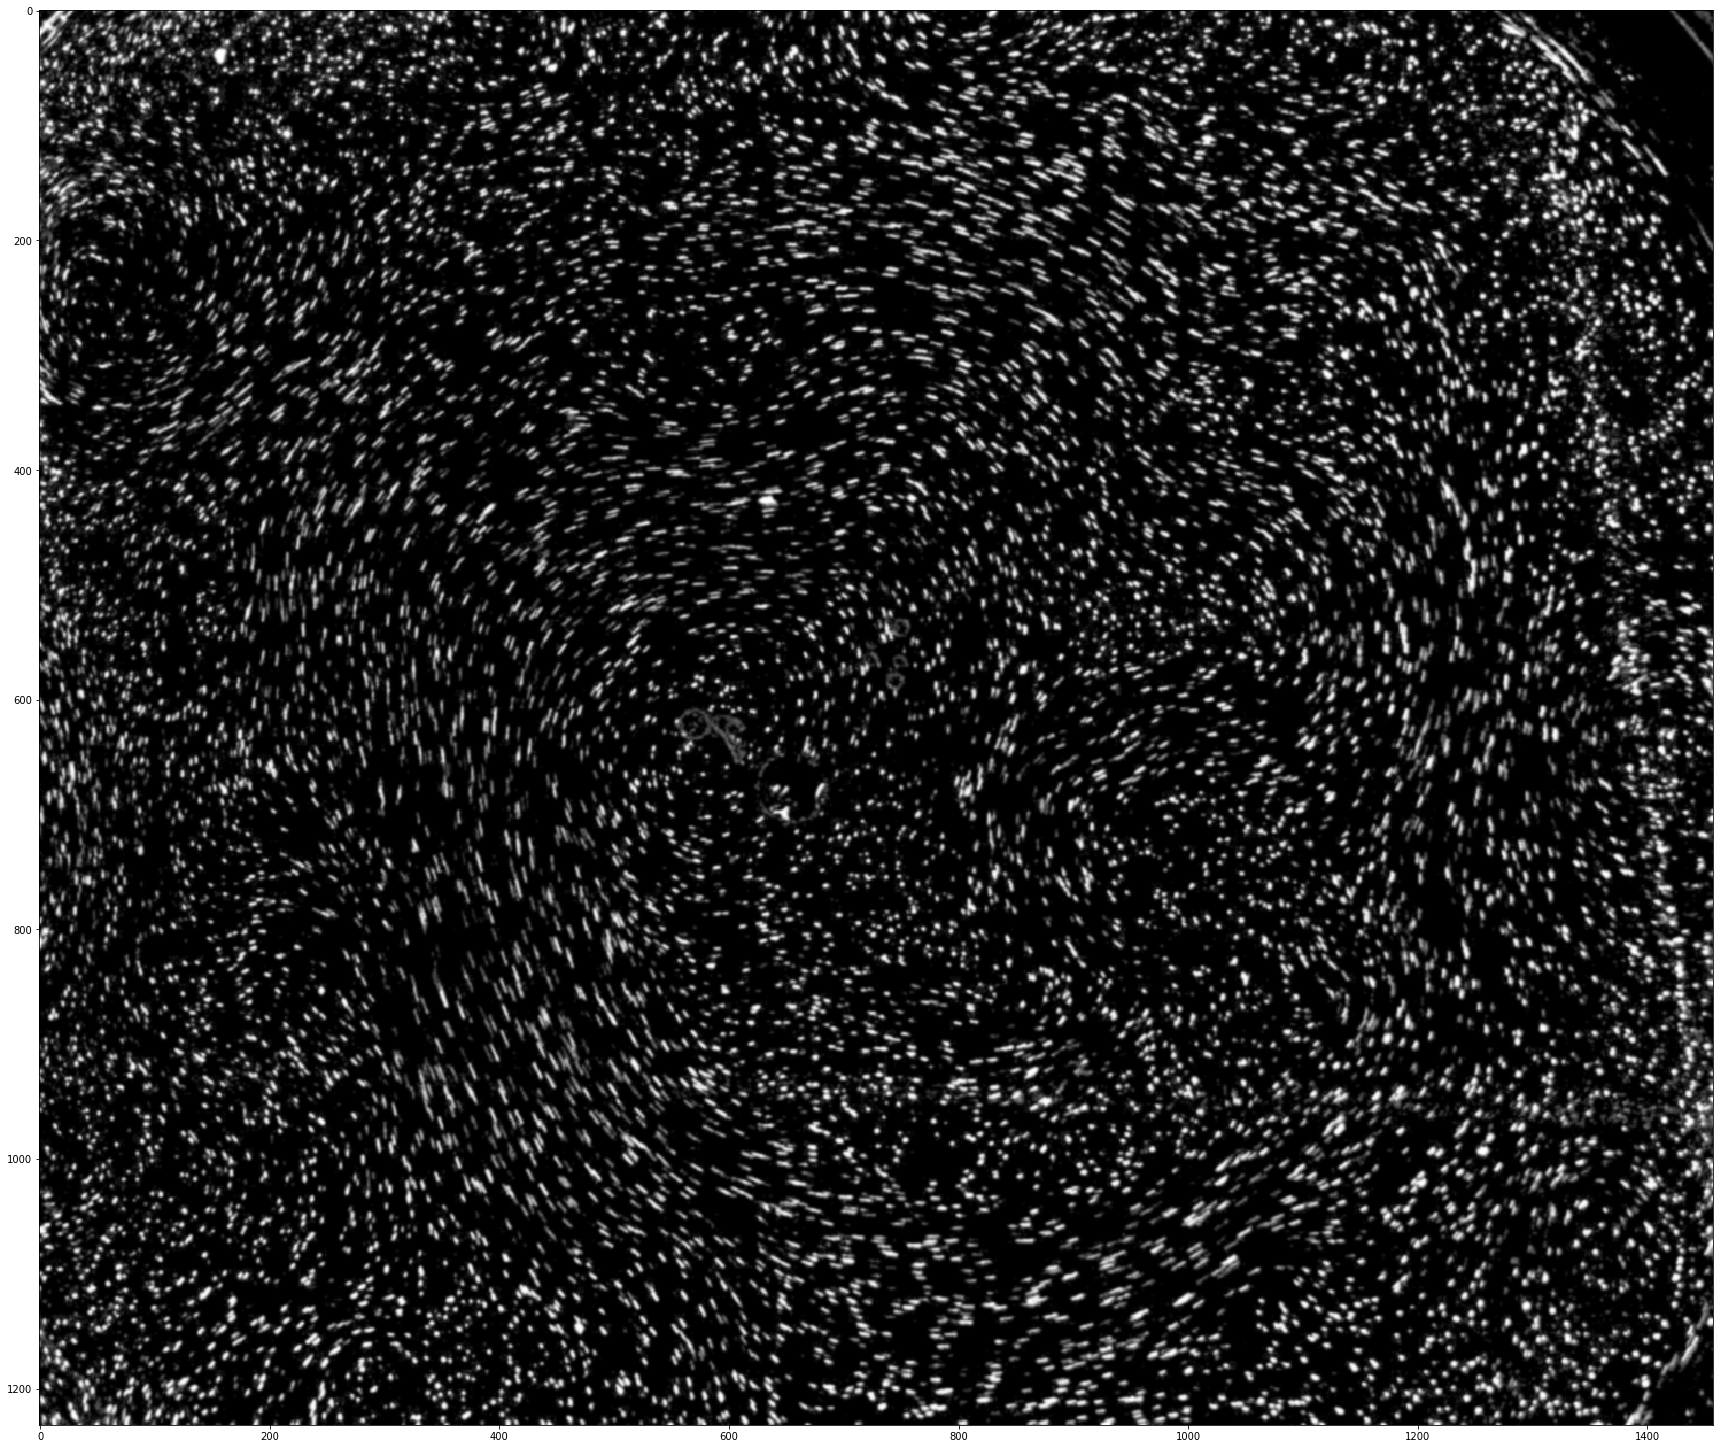

In [5]:
#imageFile='data/Test_image_experiment.jpg'
imageFile='data/libration05hz05hz34deg_21ms30fps000000020.jpg'
imageFile2='data/libration05hz05hz34deg_21ms30fps000000021.jpg'
image=Image.open(imageFile).convert('L')
image2=Image.open(imageFile2).convert('L')
# The background needs to be removed due to CCD matrix jitter. 
# We use here a threshold value below which all points are set to black.

threshold = 50
data = np.array(image.getdata())
data[data < threshold] = 0
image.putdata(data)

# After Thresholding we apply a Gaussian Filter to avoid abrupt
im = image.filter(ImageFilter.GaussianBlur(radius = 1))

figure(figsize=(30,30))
imshow(im, cmap='gray',vmin=0,vmax=255)

## Testing different rescaling on a single interrogationWindows 
The interrogation window's size is fixed to 48x48, depending on the seeding's density, the size of the particles, the flow speed and the camera resolution, it may be necessary to resize the image. Although resizing may help, it is wise to perform the experiment in conditions as close as possible from the training of the network. You aim at:

    -2 to 10 streaks per image.
    -streak thickness ~ particle radius ~ 2 to 4px
    -max displacement ~24px
    
In order to decide if rescaling is beneficial, we perform a test on few randomly chosen interrogation windows from the image. 0.5->image size / 2,  1.5->image size x 1.5, 
    



Testing finished, took 0.1262s. 79.23 images/sec.
Testing finished, took 0.1662s. 60.18 images/sec.
Testing finished, took 0.1544s. 64.78 images/sec.


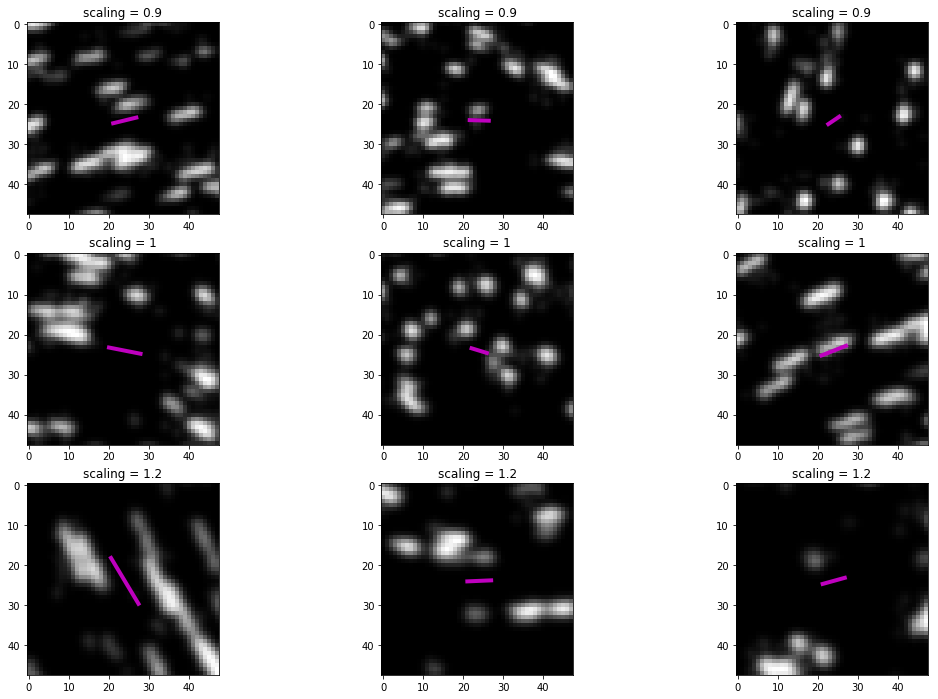

In [6]:
scaling=[0.9,1,1.2]
nTestSubwindows=3

interrogationWindows=np.empty(shape=(len(scaling),nTestSubwindows,1,\
                                     CNN_width,CNN_height))
imagesTOprocess=np.empty(shape=(nTestSubwindows,1,\
                                     CNN_width,CNN_height))
results=[]
count=0
for i in range(len(scaling)):
    newImageSize=(int(im.size[0]*scaling[i]),int(im.size[1]*scaling[i]))
    _imResized=im.resize(newImageSize,Image.ANTIALIAS)
    _x,_y,splittedImages,_,_ =\
    splitImage(np.array(_imResized),CNN_width,CNN_height,overlap)
    indices = random.randint(0, len(splittedImages), nTestSubwindows)
    for j in range(indices.size):
        interrogationWindows[i,j,0,:,:]=np.array(Image.fromarray(\
                                    splittedImages[indices[j],:,:]))
        
        count+=1

for i in range(len(scaling)):
    imagesTOprocess[:,0,:,:]=interrogationWindows[i,:,0,:,:]

    inputs = torch.from_numpy(np.array(imagesTOprocess) / 255).type(torch.FloatTensor)
    inputs = inputs.to(device)
    
    prediction=np.zeros((n_ensemble_members,imagesTOprocess.shape[0],2))
    averagedPrediction=np.zeros((imagesTOprocess.shape[0],2))

    start_time=time.time()
    for n in range(n_ensemble_members):
        net = net_ensemble[n]
        net.eval()

        net_outputs = net(inputs)
        if 'cuda' in device.type:
            net_outputs = net_outputs.cpu()

        prediction[n,:,:]=scaler.inverse_transform(net_outputs.data.numpy())
        averagedPrediction += prediction[n,:,:]

    elapsed_time = time.time() - start_time
    print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                                n_ensemble_members / elapsed_time))

    averagedPrediction /= n_ensemble_members
    results.append(np.array(averagedPrediction))

results=np.array(results)       

fig=figure()   
count=1
for i in range(len(scaling)):
    for j in range(indices.size):
        ax = fig.add_subplot(nTestSubwindows,len(scaling),count)
        count+=1
        imshow(interrogationWindows[i,j,0,:,:],cmap='gray')
        ax.set_title('scaling = {}'.format(scaling[i]))
        displacement=results[i,j,0]
        angle=results[i,j,1]
    
        xc = CNN_width / 2
        yc = CNN_height / 2

        x0 = xc - math.cos(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.
        x1 = xc + math.cos(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.

        y0 = yc - math.sin(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.
        y1 = yc + math.sin(results[i,j,1] * np.pi / 180) * results[i,j,0] / 2.

        xy = np.array(([x0, y0], [x1, y1]));

        line = patches.Polygon(xy, color = 'm', linewidth = 4)

        ax.add_patch(line)

fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
show()

## Apply network ensemble to the entire image

Based on the previous tests, resize the whole image before applying the Convolution Network. You have two choices:

    1-applyEnsenble=True: Uses the N trained networks.
    2-applyEnsenble=False: Use only one of the N networks.
    
The first option takes longer but allows one to to estimate uncertainties

In [7]:
# Define a region of interest and a rescaling of the image:
scaling=0.9
applyEnsemble=True
# Which Network of the ensemble if applyEnsemble=False
n=3 
overlap=24

newImageSize=(int(im.size[0]*scaling),int(im.size[1]*scaling))
imResized=im.resize(newImageSize,Image.ANTIALIAS)
    
start_time=time.time()
_x,_y,splittedImages,nh,nw =splitImage(np.array(imResized),CNN_width,CNN_height,\
                                       overlap)

#reshape the data to match the CNN format filter
imagesTOprocess = np.zeros([ splittedImages.shape[0],1, splittedImages.shape[1], \
                            splittedImages.shape[2]], dtype=np.float32)
imagesTOprocess[:,0,:,:]=splittedImages[:,:,:]
elapsed_time = time.time() - start_time
print("Splitting took {:.4f}s.".format(elapsed_time))

ximage = torch.from_numpy(imagesTOprocess / 255).type(torch.FloatTensor)

params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

input_dataset = TensorDataset(ximage)
input_loader = DataLoader(input_dataset, **params)

prediction=np.zeros((n_ensemble_members,imagesTOprocess.shape[0],2))
predictionSingle=np.zeros((imagesTOprocess.shape[0],2))
averagedPrediction=np.zeros((imagesTOprocess.shape[0],2))
stdPrediction=np.zeros((imagesTOprocess.shape[0],2))
displacement=np.zeros((imagesTOprocess.shape[0]))
angle=np.zeros((imagesTOprocess.shape[0]))
stdDisplacement=np.zeros((imagesTOprocess.shape[0]))
stdAngle=np.zeros((imagesTOprocess.shape[0]))

start_time=time.time()
if applyEnsemble:
    print('Processing with Ensemble')
    for n in range(n_ensemble_members):
        net = net_ensemble[n]
        net.eval()
        
        ypredicted = np.empty(shape=(0,2))
        for inputs in input_loader:
            inputs = inputs[0].to(device)
            
            # Forward pass
            net_outputs = net(inputs)
    
            if 'cuda' in device.type:
                net_outputs = net_outputs.cpu()
    
            ypredicted = np.concatenate((ypredicted, net_outputs.data.numpy()))
        
        prediction[n,:,:]=scaler.inverse_transform(ypredicted)

    elapsed_time = time.time() - start_time
    print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                                n_ensemble_members / elapsed_time))

    averagedPrediction=np.mean(prediction, axis=0)
    stdPrediction=np.std(prediction, axis=0)
    
    displacement=np.reshape(averagedPrediction[:,0],(nh,nw))
    stdDisplacement=np.reshape(stdPrediction[:,0],(nh,nw))
    angle=np.reshape(averagedPrediction[:,1],(nh,nw))
    stdAngle=np.reshape(stdPrediction[:,1],(nh,nw))
else:
    print('Processing with only network #: {}'.format(n))        
    net = net_ensemble[n]
    net.eval()
    # Forward pass
    net_outputs = net(inputs)
    if 'cuda' in device.type:
        net_outputs = net_outputs.cpu()

    predictionSingle=scaler.inverse_transform(val_outputs.data.numpy())
    elapsed_time = time.time() - start_time
    print("Testing finished, took {:.4f}s.".format(elapsed_time))

    displacement = np.reshape(predictionSingle[:,0], (nh,nw))
    angle = np.reshape(predictionSingle[:,1], (nh,nw))
    
x = np.reshape(np.array(_x), (nh,nw))
y = np.reshape(np.array(_y), (nh,nw))

Splitting took 0.0958s.
Processing with Ensemble
Testing finished, took 11.5063s. 0.87 images/sec.


## Plot final results

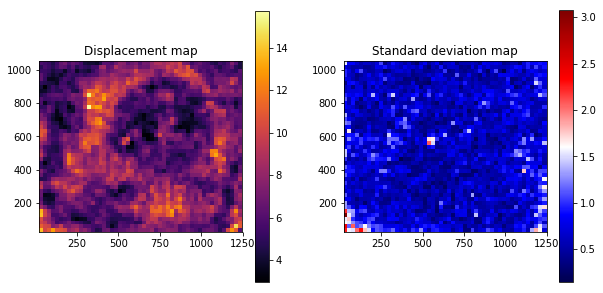

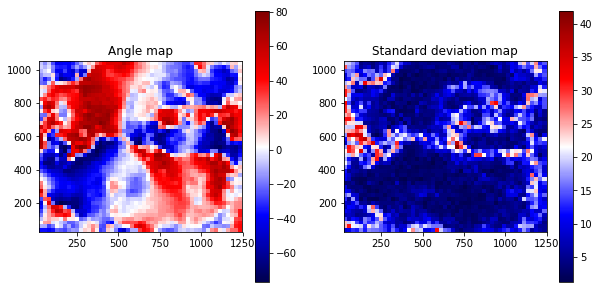

/Users/jeromenoir/anaconda3/envs/pytorchEnv/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


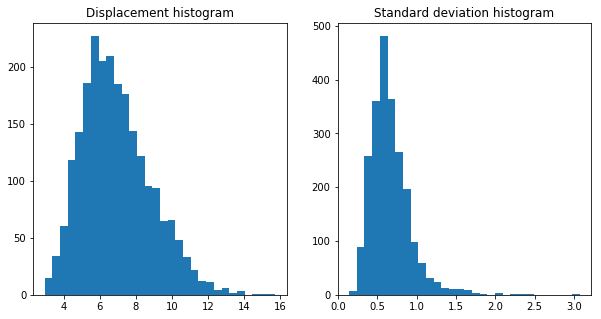

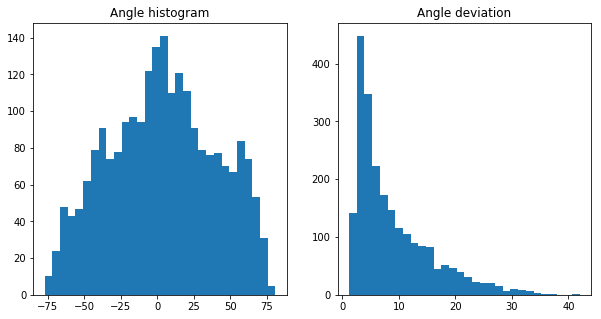

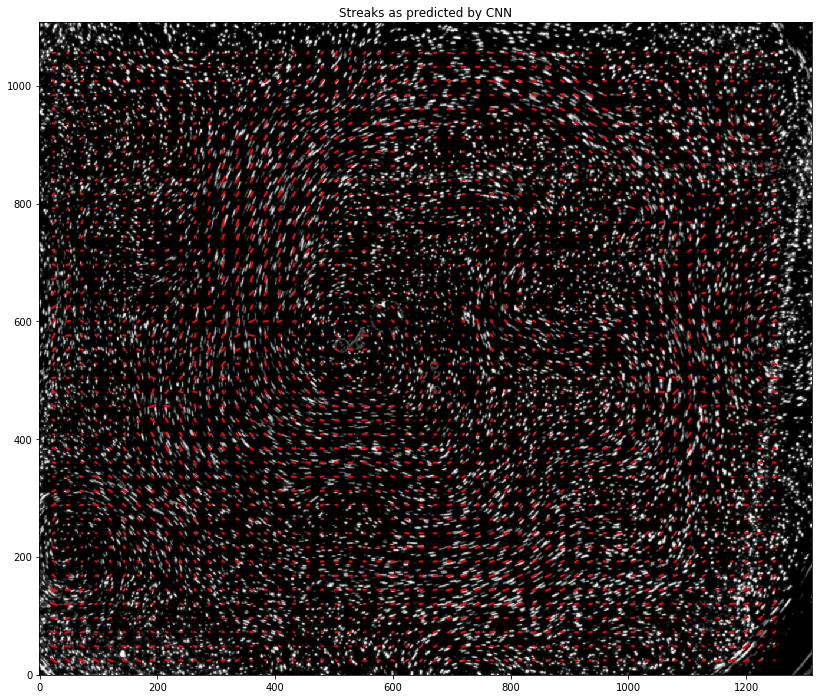

In [8]:
figDisplacement=figure(figsize=(10,5))

if applyEnsemble:
    subplot(1,2,1)
    meanDispMap=pcolormesh(x,y,\
                           displacement,cmap='inferno')
    colorbar(meanDispMap)
    title('Displacement map')
    axis('scaled')
    
    subplot(1,2,2)
    stdDispMap=pcolormesh(x,y,\
                          stdDisplacement,cmap='seismic')
    colorbar(stdDispMap)
    title('Standard deviation map')
    axis('scaled')
else:
    title('Displacement map using only network #{}'.format(n))    
    pcolormesh(x,y,displacement,cmap='inferno')
    axis('scaled')
show()


figAngle=figure(figsize=(10,5))
if applyEnsemble:
    subplot(1,2,1)
    meanAngleMAp=pcolormesh(x,y,angle,cmap='seismic')
    colorbar(meanAngleMAp)
    title('Angle map')
    axis('scaled')
    
    subplot(1,2,2)
    stdAngleMAp=pcolormesh(x,y,stdAngle,cmap='seismic')
    colorbar(stdAngleMAp)
    title('Standard deviation map')
    axis('scaled')
else:
    title('Angle map using only network #{}'.format(n))    
    pcolormesh(x,y,angle,cmap='inferno')
    axis('scaled')
show()


figstdDisplacement=figure(figsize=(10,5))
if applyEnsemble:
    subplot(1,2,1)
    hDisp=hist(displacement.flatten(),30)
    title('Displacement histogram')
    subplot(1,2,2)
    hStd=hist(stdDisplacement.flatten(),30)
    title('Standard deviation histogram')
else:
    title('Displacement histogram using only network #{}'.format(n))
    hDisp=hist(displacement.flatten(),30)
    
    
figstdAngle=figure(figsize=(10,5))
if applyEnsemble:
    subplot(1,2,1)
    hAngle=hist(angle.flatten(),30)
    title('Angle histogram')
    subplot(1,2,2)
    hStd=hist(stdAngle.flatten(),30)
    title('Angle deviation')
else:
    title('Displacement histogram using only network #{}'.format(n))
    hAngle=hist(angle.flatten(),30)
    title('Standard deviation histogram')
    
fig=figure()
imshow(np.array(imResized),origin='lower')
gray()
ax=ax = fig.add_subplot(1,1,1)

x0 = _x - np.cos(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.
x1 = _x + np.cos(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.

y0 = _y - np.sin(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.
y1 = _y + np.sin(angle.flatten() * np.pi / 180) * displacement.flatten() / 2.

xy = np.array(([x0, y0], [x1, y1]))
for i in range(0,xy.shape[2]):
        line=patches.Polygon(xy[:,:,i], color = 'r', linewidth = 2)
        ax.add_patch(line)

fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
title('Streaks as predicted by CNN')

outFile=imageFile[:-4]+'_CNN.pdf'
savefig(outFile)
show()


## use openPIV for comparison

In [9]:
#openPIV calculation on the data set for CNN validation



window_sizePIV=48
search_area_sizePIV=64
overlapPIV=24
dtPIV=1


def computePIV(frame_a,frame_b,window_sizePIV=48,search_area_sizePIV=64,overlapPIV=24,dtPIV=1):
    
    import openpiv.tools
    import openpiv.process
    import openpiv.scaling
    import openpiv.validation
    import openpiv.filters
    
    frame_a=np.array(frame_a,dtype=np.int32)#frame_a.astype(np.int32)
    frame_b=np.array(frame_b,dtype=np.int32)#frame_b.astype(np.int32)


    u, v, sig2noise = openpiv.process.extended_search_area_piv( \
            frame_a, frame_b, \
            window_size=window_sizePIV, \
            overlap=overlapPIV, \
            dt=dtPIV, \
            search_area_size=search_area_sizePIV, \
            sig2noise_method='peak2peak' )

    x, y = openpiv.process.get_coordinates( \
            image_size=frame_a.shape, \
            window_size=window_sizePIV, 
            overlap=overlapPIV )
    
    u, v, mask = openpiv.validation.local_median_val( u, v,7,7,size=1 )
    u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=5,kernel_size=2)

    return x,y,u,v


xpiv,ypiv,upiv,vpiv=computePIV(image,image2,window_sizePIV,\
 search_area_sizePIV,overlapPIV,dtPIV)
ypiv=ypiv.max()-ypiv
vpiv=-vpiv


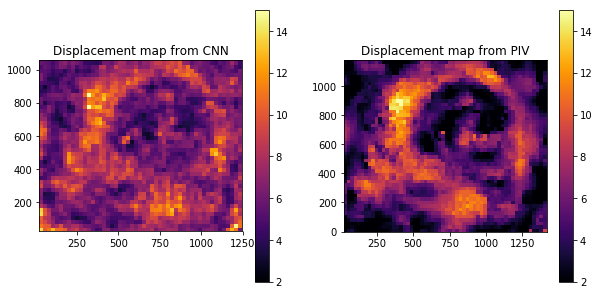

Mean displacement from PIV=5.603367035516273
Mean displacement from CNN=6.942909706132098


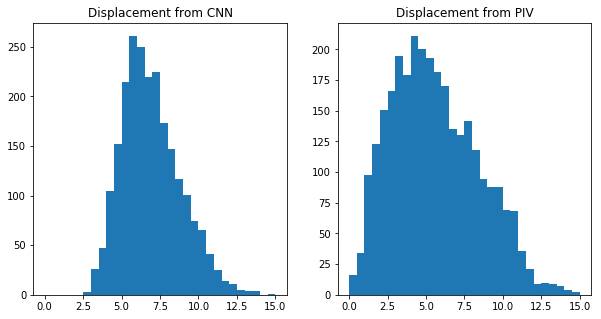

In [10]:
pivdisplacement=np.sqrt(upiv**2+vpiv**2)

figDisplacementComp=figure(figsize=(10,5))

if applyEnsemble:
    subplot(1,2,1)
    meanDispMap=pcolormesh(x,y,\
                           displacement,cmap='inferno',\
                          vmin=2, vmax=15)
    colorbar(meanDispMap)
    title('Displacement map from CNN')
    axis('scaled')
    
    subplot(1,2,2)
    stdDispMap=pcolormesh(xpiv,ypiv,\
                          pivdisplacement,cmap='inferno',\
                          vmin=2, vmax=15)
    colorbar(stdDispMap)
    title('Displacement map from PIV')
    axis('scaled')
else:
    title('Displacement map using only network #{}'.format(n))    
    pcolormesh(x,y,displacement,cmap='inferno')
    axis('scaled')
show()

figDisplacementHist=figure(figsize=(10,5))


subplot(1,2,1)
hDisp=hist(displacement.flatten(),30, range=(0,15))
title('Displacement from CNN')


subplot(1,2,2)
hDisp=hist(pivdisplacement.flatten(),30,range=(0,15))
title('Displacement from PIV')

    
    
print('Mean displacement from PIV={}'.format(np.mean(pivdisplacement)))
print('Mean displacement from CNN={}'.format(np.mean(displacement)))